In [1]:
import numpy as np
import pandas as pd

import math
from numpy.linalg import norm

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

import warnings
warnings.filterwarnings("ignore")

import re
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import tensorflow_hub as hub

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_excel('review.xlsx')
data.drop(['Unnamed: 13'], axis=1, inplace=True)
data.head()

,FDA_Chapter,FDA_Section,FDA_Code,FDA_Subpart,FDA_Description,matched,score,HC_Code,HC_Chapter,HC_Section,HC_Subpart,HC_Description,truth
0,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Buildings and Facilities,"""211.56""",Sanitation.,"(a) Any building used in the manufacture, proc...",1,0.773877,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y
1,CURRENT GOOD MANUFACTURING PRACTICE FOR TYPE A...,Construction and Maintenance of Facilities and...,"""226.20""",Buildings.,Buildings in which Type A medicated article(s)...,1,0.724563,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y
2,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Buildings and Facilities,"""211.58""",Maintenance.,"Any building used in the manufacture, processi...",1,0.717186,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y
3,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Equipment,"""211.63""","Equipment design, size, and location.","Equipment used in the manufacture, processing,...",1,0.742327,C.02.005,Drugs,Good Manufacturing Practices,Equipment,The equipment with which a lot or batch of a d...,Y
4,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Records and Reports,"""211.182""",Equipment cleaning and use log.,"A written record of major equipment cleaning, ...",1,0.628404,C.02.007,Drugs,Good Manufacturing Practices,Sanitation,(1) Every person who fabricates or packages/la...,Y


In [3]:
data['fda_desc_cleaned']=''
data['hc_desc_cleaned']=''

# Pre-processing FDA Descriptions
lemmatizer = WordNetLemmatizer()
pattern1 = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
pattern2 = '[0-9]'
for i in range(0,len(data)):
        sent_ref = data.iloc[i]['FDA_Description']
#         sent_ref = sent_ref.lower() # convert to lower case
        word_list = nltk.word_tokenize(sent_ref)
        sent_ref = ' '.join([lemmatizer.lemmatize(w) for w in word_list]) # lemmatize
        sent_ref = re.sub(r'\([^)]*\)', '', sent_ref) # remove characters which are within () and []
        sent_ref = pattern1.sub('', sent_ref) # remove stopwords
        sent_ref = re.sub(r'[^\w\s]','',sent_ref) # remove spaces (new line, tabs etc)
        sent_ref = re.sub(pattern2, '', sent_ref) # remove numbers
        sent_ref = " ".join(sent_ref.split()) # remove whitespaces, if any
        data['fda_desc_cleaned'][i] = sent_ref
        
# Pre-processing Health Canada Descriptions
lemmatizer = WordNetLemmatizer()
pattern1 = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
pattern2 = '[0-9]'
for i in range(0,len(data)):
        sent_ref = data.iloc[i]['HC_Description']
#         sent_ref = sent_ref.lower() # convert to lower case
        word_list = nltk.word_tokenize(sent_ref)
        sent_ref = ' '.join([lemmatizer.lemmatize(w) for w in word_list]) # lemmatize
        sent_ref = re.sub(r'\([^)]*\)', '', sent_ref) # remove characters which are within parenthesis
        sent_ref = pattern1.sub('', sent_ref) # remove stopwords
        sent_ref = re.sub(r'[^\w\s]','',sent_ref) # remove spaces (new line, tabs etc)
        sent_ref = re.sub(pattern2, '', sent_ref) # remove numbers
        sent_ref = " ".join(sent_ref.split()) # remove whitespaces, if any
        data['hc_desc_cleaned'][i] = sent_ref

In [4]:
def angular_distance(src, tgt):
    cos_sim = cosine_similarity(src, tgt)
    np.fill_diagonal(cos_sim, 1)
    distance = 1 - (np.arccos(cos_sim) / math.pi)
    return distance

def cosine_sim(src, tgt):
    similarity = cosine_similarity(src, tgt)
    return similarity


def manhattan_dist(src, tgt):
    distance = manhattan_distances(src, tgt)
    return distance


def euclidean_dist(src, tgt):
    distance = euclidean_distances(src, tgt)
    return distance

In [5]:
def theta(src, tgt):
    similarity_ = cosine_sim(src, tgt)
    np.fill_diagonal(similarity_, 1)
    theta_ = np.arccos(similarity_) + math.radians(10)
    return theta_


def magnitude_difference(src, tgt):
    src_len = len(src)
    src_norm = norm(src, axis=1).repeat(src_len).reshape(src_len, -1)
    tgt_norm = norm(tgt, axis=1)
    difference_ = np.abs(src_norm - tgt_norm)
    return difference_


def triangle_area_similarity(src, tgt, theta_):
    src_len = len(src)
    src_norm = norm(src, axis=1).repeat(src_len).reshape(src_len, -1)
    tgt_norm = norm(tgt, axis=1)
    triangle_similarity_ = (src_norm * tgt_norm * np.sin(theta_)) / 2
    return triangle_similarity_


def sector_area_similarity(src, tgt, theta_):
    distance_ = euclidean_dist(src, tgt)
    difference_ = magnitude_difference(src, tgt)
    sector_similarity_ = math.pi * ((distance_ + difference_) ** 2)
    sector_similarity_ *= theta_ / 360
    return sector_similarity_


def triangle_sector_similarity(src, tgt):
    theta_ = theta(src, tgt)
    triangle_similarity_ = triangle_area_similarity(src, tgt, theta_)
    sector_similarity_ = sector_area_similarity(src, tgt, theta_)
    ts_ss_ = triangle_similarity_ * sector_similarity_
    return ts_ss_

In [6]:
embedder = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [7]:
data['angular_distance'] = ''
data['cosine']=''
data['manhattan_distance']=''
data['euclidean_distance']=''
data['tss']=''

In [8]:
for i in range(0,len(data)):
    sent1 = data['fda_desc_cleaned'][i]
    sent2 = data['hc_desc_cleaned'][i]
    enc_sentences = embedder([sent1,sent2])
    data['angular_distance'][i] = angular_distance(enc_sentences[0:1],enc_sentences)[0,1]
    data['cosine'][i] = cosine_sim(enc_sentences[0:1],enc_sentences)[0,1]
    data['manhattan_distance'][i] = manhattan_dist(enc_sentences[0:1],enc_sentences)[0,1]
    data['euclidean_distance'][i] = euclidean_dist(enc_sentences[0:1],enc_sentences)[0,1]
    data['tss'][i] = triangle_sector_similarity(enc_sentences[0:1],enc_sentences)[0,1]
    
data.head(3)

,FDA_Chapter,FDA_Section,FDA_Code,FDA_Subpart,FDA_Description,matched,score,HC_Code,HC_Chapter,HC_Section,HC_Subpart,HC_Description,truth,fda_desc_cleaned,hc_desc_cleaned,angular_distance,cosine,manhattan_distance,euclidean_distance,tss
0,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Buildings and Facilities,"""211.56""",Sanitation.,"(a) Any building used in the manufacture, proc...",1,0.773877,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y,Any building used manufacture processing packi...,The premise lot batch drug fabricated packaged...,0.660773,0.483879,18.2535,1.01599,0.00528367
1,CURRENT GOOD MANUFACTURING PRACTICE FOR TYPE A...,Construction and Maintenance of Facilities and...,"""226.20""",Buildings.,Buildings in which Type A medicated article(s)...,1,0.724563,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y,Buildings Type A medicated article manufacture...,The premise lot batch drug fabricated packaged...,0.653024,0.462435,18.8518,1.03689,0.00565642
2,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Buildings and Facilities,"""211.58""",Maintenance.,"Any building used in the manufacture, processi...",1,0.717186,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y,Any building used manufacture processing packi...,The premise lot batch drug fabricated packaged...,0.6382,0.420655,19.4668,1.07642,0.00640673


#### angular distance

In [9]:
print(max(data.angular_distance))
print(min(data.angular_distance))

0.7930748
0.5559957


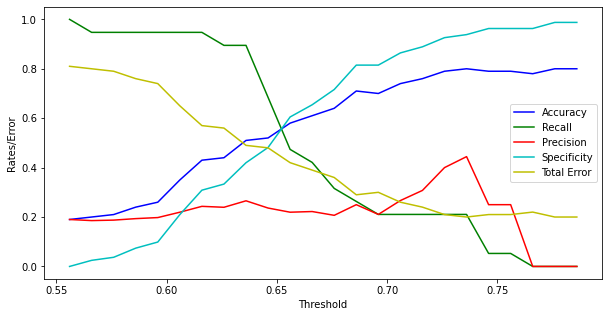

In [10]:
max_value = max(data.angular_distance)
min_value = min(data.angular_distance)

threshold = np.arange(min_value,max_value,0.01)

precision=[]
accuracy=[]
recall=[]
specificity=[]

for i in range(0,len(threshold)):
    data['y_pred'] = ''
    data['cm'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['angular_distance'][j] >= threshold[i]):
            data['y_pred'][j] = 'Y'
        else:
            data['y_pred'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'N'):
            data['cm'][k] = 'FN'
        else:
            data['cm'][k] = 'TN'
    
    
    tp = data.cm.value_counts().TP if 'TP' in data.cm.value_counts() is not None else 0
    tn = data.cm.value_counts().TN if 'TN' in data.cm.value_counts() is not None else 0
    fp = data.cm.value_counts().FP if 'FP' in data.cm.value_counts() is not None else 0
    fn = data.cm.value_counts().FN if 'FN' in data.cm.value_counts() is not None else 0

    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    precision.append(prec)
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    recall.append(rec)
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    specificity.append(spec)
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    accuracy.append(acc)

plt.figure(figsize=(10,5))

plt.plot(threshold, accuracy, color = 'b', label = 'Accuracy')
plt.plot(threshold, recall, color = 'g', label = 'Recall')
plt.plot(threshold, precision, color = 'r', label = 'Precision')
plt.plot(threshold, specificity, color = 'c', label = 'Specificity')
plt.plot(threshold, [1-x for x in accuracy], color = 'y', label = 'Total Error')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [11]:
threshold = np.arange(0.60,0.66,0.01)
results = pd.DataFrame(threshold,columns=['threshold'])
results['TP'] = ''
results['TN'] = ''
results['FP'] = ''
results['FN'] = ''

results['specificity'] = ''
results['recall']=''
results['precision']=''
results['accuracy']=''

for i in range(0,len(threshold)):
    threshold = results['threshold'][i]
    data['y_angular'] = ''
    data['cm_angular'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['angular_distance'][j] >= threshold):
            data['y_angular'][j] = 'Y'
        else:
            data['y_angular'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_angular'][k] == 'Y'):
            data['cm_angular'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_angular'][k] == 'Y'):
            data['cm_angular'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_angular'][k] == 'N'):
            data['cm_angular'][k] = 'FN'
        else:
            data['cm_angular'][k] = 'TN'
    
    
    tp = data.cm_angular.value_counts().TP if 'TP' in data.cm_angular.value_counts() is not None else 0
    results['TP'][i] = tp
    
    tn = data.cm_angular.value_counts().TN if 'TN' in data.cm_angular.value_counts() is not None else 0
    results['TN'][i] = tn
    
    fp = data.cm_angular.value_counts().FP if 'FP' in data.cm_angular.value_counts() is not None else 0
    results['FP'][i] = fp
    
    fn = data.cm_angular.value_counts().FN if 'FN' in data.cm_angular.value_counts() is not None else 0
    results['FN'][i] = fn
    
    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    results['precision'][i] = prec
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    results['recall'][i] = rec
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    results['accuracy'][i] = acc 
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    results['specificity'][i] = spec

print('---------- USE: Angular Distance ----------')
results

---------- USE: Angular Distance ----------


,threshold,TP,TN,FP,FN,specificity,recall,precision,accuracy
0,0.60,18,12,69,1,0.148148,0.947368,0.206897,0.3
1,0.61,18,18,63,1,0.222222,0.947368,0.222222,0.36
2,0.62,18,27,54,1,0.333333,0.947368,0.25,0.45
3,0.63,17,31,50,2,0.382716,0.894737,0.253731,0.48
4,0.64,15,38,43,4,0.469136,0.789474,0.258621,0.53
5,0.65,12,47,34,7,0.580247,0.631579,0.26087,0.59
6,0.66,9,50,31,10,0.617284,0.473684,0.225,0.59


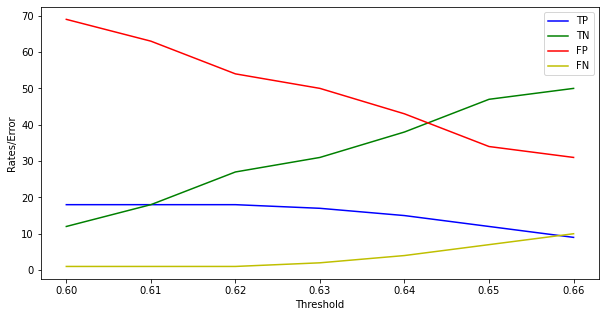

In [12]:
tp_list = results.TP.to_list()
tn_list = results.TN.to_list()
fp_list = results.FP.to_list()
fn_list = results.FN.to_list()

plt.figure(figsize=(10,5))

threshold = np.arange(0.60,0.66,0.01)

plt.plot(threshold,tp_list, color = 'b', label = 'TP')
plt.plot(threshold,tn_list, color = 'g', label = 'TN')
plt.plot(threshold,fp_list, color = 'r', label = 'FP')
plt.plot(threshold,fn_list, color = 'y', label = 'FN')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [13]:
data['y_angular']=''
for i in range(0,len(data)):
    if data['angular_distance'][i] >= 0.64:
        data['y_angular'][i] = 'Y'
    else:
        data['y_angular'][i] = 'N'
        
data['cm_angular']=''
for k in range(0,len(data)):
    if (data['truth'][k] == 'Y') and (data['y_angular'][k] == 'Y'):
        data['cm_angular'][k] = 'TP'
    elif (data['truth'][k] == 'N') and (data['y_angular'][k] == 'Y'):
        data['cm_angular'][k] = 'FP'
    elif (data['truth'][k] == 'Y') and (data['y_angular'][k] == 'N'):
        data['cm_angular'][k] = 'FN'
    else:
        data['cm_angular'][k] = 'TN'
        
tp = data.cm_angular.value_counts().TP if 'TP' in data.cm_angular.value_counts() is not None else 0
print('true positives:',tp)
tn = data.cm_angular.value_counts().TN if 'TN' in data.cm_angular.value_counts() is not None else 0
print('true negatives:',tn)
fp = data.cm_angular.value_counts().FP if 'FP' in data.cm_angular.value_counts() is not None else 0
print('false positives:',fp)
fn = data.cm_angular.value_counts().FN if 'FN' in data.cm_angular.value_counts() is not None else 0
print('false negatives:',fn)

precision = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
print('precision:',precision)
    
recall = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
print('recall:',recall)   

acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
print('accuracy:',acc)

true positives: 15
true negatives: 38
false positives: 43
false negatives: 4
precision: 0.25862068965517243
recall: 0.7894736842105263
accuracy: 0.53


#### manhattan

In [14]:
print(max(data.manhattan_distance))
print(min(data.manhattan_distance))

23.16580531468935
11.348641779052741


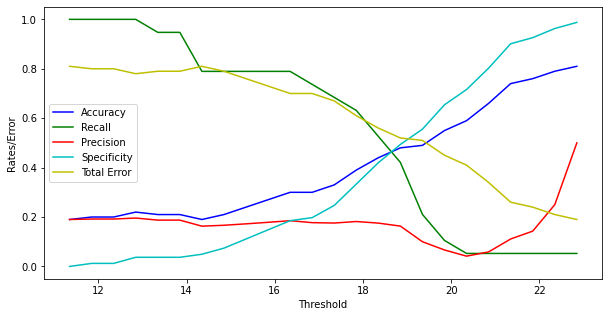

In [15]:
max_value = max(data.manhattan_distance)
min_value = min(data.manhattan_distance)
threshold = np.arange(min_value,max_value,0.5)

precision=[]
accuracy=[]
recall=[]
specificity=[]

for i in range(0,len(threshold)):
    data['y_pred'] = ''
    data['cm'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['manhattan_distance'][j] >= threshold[i]):
            data['y_pred'][j] = 'Y'
        else:
            data['y_pred'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'N'):
            data['cm'][k] = 'FN'
        else:
            data['cm'][k] = 'TN'
    
    
    tp = data.cm.value_counts().TP if 'TP' in data.cm.value_counts() is not None else 0
    tn = data.cm.value_counts().TN if 'TN' in data.cm.value_counts() is not None else 0
    fp = data.cm.value_counts().FP if 'FP' in data.cm.value_counts() is not None else 0
    fn = data.cm.value_counts().FN if 'FN' in data.cm.value_counts() is not None else 0

    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    precision.append(prec)
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    recall.append(rec)
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    accuracy.append(acc)
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    specificity.append(spec)

plt.figure(figsize=(10,5))

plt.plot(threshold, accuracy, color = 'b', label = 'Accuracy')
plt.plot(threshold, recall, color = 'g', label = 'Recall')
plt.plot(threshold, precision, color = 'r', label = 'Precision')
plt.plot(threshold, specificity, color = 'c', label = 'Specificity')
plt.plot(threshold, [1-x for x in accuracy], color = 'y', label = 'Total Error')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [16]:
threshold = np.arange(17,18,0.1)
results2 = pd.DataFrame(threshold,columns=['threshold'])
results2['TP'] = ''
results2['TN'] = ''
results2['FP'] = ''
results2['FN'] = ''

results2['specificity'] = ''
results2['recall']=''
results2['precision']=''
results2['accuracy']=''

for i in range(0,len(threshold)):
    threshold = results2['threshold'][i]
    data['y_manhattan'] = ''
    data['cm_manhattan'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['manhattan_distance'][j] >= threshold):
            data['y_manhattan'][j] = 'Y'
        else:
            data['y_manhattan'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_manhattan'][k] == 'Y'):
            data['cm_manhattan'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_manhattan'][k] == 'Y'):
            data['cm_manhattan'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_manhattan'][k] == 'N'):
            data['cm_manhattan'][k] = 'FN'
        else:
            data['cm_manhattan'][k] = 'TN'
    
    
    tp = data.cm_manhattan.value_counts().TP if 'TP' in data.cm_manhattan.value_counts() is not None else 0
    results2['TP'][i] = tp
    
    tn = data.cm_manhattan.value_counts().TN if 'TN' in data.cm_manhattan.value_counts() is not None else 0
    results2['TN'][i] = tn
    
    fp = data.cm_manhattan.value_counts().FP if 'FP' in data.cm_manhattan.value_counts() is not None else 0
    results2['FP'][i] = fp
    
    fn = data.cm_manhattan.value_counts().FN if 'FN' in data.cm_manhattan.value_counts() is not None else 0
    results2['FN'][i] = fn
    
    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    results2['precision'][i] = prec

    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    results2['recall'][i] = rec

    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    results2['accuracy'][i] = acc 
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    results2['specificity'][i] = spec

print('---------- USE: Manhattan Distance ----------')
results2

---------- USE: Manhattan Distance ----------


,threshold,TP,TN,FP,FN,specificity,recall,precision,accuracy
0,17.0,14,16,65,5,0.197531,0.736842,0.177215,0.3
1,17.1,14,16,65,5,0.197531,0.736842,0.177215,0.3
2,17.2,14,17,64,5,0.209877,0.736842,0.179487,0.31
3,17.3,13,18,63,6,0.222222,0.684211,0.171053,0.31
4,17.4,13,20,61,6,0.246914,0.684211,0.175676,0.33
5,17.5,13,23,58,6,0.283951,0.684211,0.183099,0.36
6,17.6,13,25,56,6,0.308642,0.684211,0.188406,0.38
7,17.7,12,25,56,7,0.308642,0.631579,0.176471,0.37
8,17.8,12,26,55,7,0.320988,0.631579,0.179104,0.38
9,17.9,12,27,54,7,0.333333,0.631579,0.181818,0.39


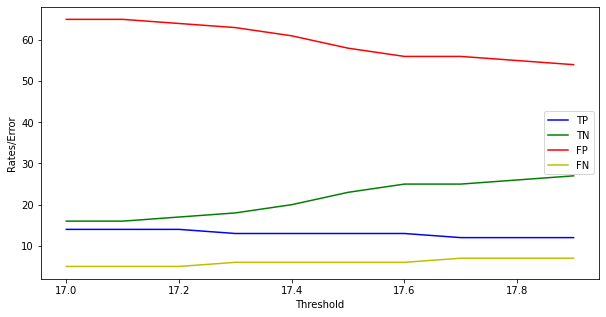

In [17]:
tp_list = results2.TP.to_list()
tn_list = results2.TN.to_list()
fp_list = results2.FP.to_list()
fn_list = results2.FN.to_list()

plt.figure(figsize=(10,5))

threshold = np.arange(17,18,0.1)

plt.plot(threshold,tp_list, color = 'b', label = 'TP')
plt.plot(threshold,tn_list, color = 'g', label = 'TN')
plt.plot(threshold,fp_list, color = 'r', label = 'FP')
plt.plot(threshold,fn_list, color = 'y', label = 'FN')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [18]:
data['y_manhattan']=''
for i in range(0,len(data)):
    if data['manhattan_distance'][i] >= 17.6:
        data['y_manhattan'][i] = 'Y'
    else:
        data['y_manhattan'][i] = 'N'
        
data['cm_manhattan']=''
for k in range(0,len(data)):
    if (data['truth'][k] == 'Y') and (data['y_manhattan'][k] == 'Y'):
        data['cm_manhattan'][k] = 'TP'
    elif (data['truth'][k] == 'N') and (data['y_manhattan'][k] == 'Y'):
        data['cm_manhattan'][k] = 'FP'
    elif (data['truth'][k] == 'Y') and (data['y_manhattan'][k] == 'N'):
        data['cm_manhattan'][k] = 'FN'
    else:
        data['cm_manhattan'][k] = 'TN'
        
tp = data.cm_manhattan.value_counts().TP if 'TP' in data.cm_manhattan.value_counts() is not None else 0
print('true positives:',tp)
tn = data.cm_manhattan.value_counts().TN if 'TN' in data.cm_manhattan.value_counts() is not None else 0
print('true negatives:',tn)
fp = data.cm_manhattan.value_counts().FP if 'FP' in data.cm_manhattan.value_counts() is not None else 0
print('false positives:',fp)
fn = data.cm_manhattan.value_counts().FN if 'FN' in data.cm_manhattan.value_counts() is not None else 0
print('false negatives:',fn)

precision = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
print('precision:',precision)

specificity = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
print('specificity:',specificity)
    
recall = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
print('recall:',recall)   

acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
print('accuracy:',acc)

true positives: 13
true negatives: 25
false positives: 56
false negatives: 6
precision: 0.18840579710144928
specificity: 0.30864197530864196
recall: 0.6842105263157895
accuracy: 0.38


#### euclidean

In [19]:
print(max(data.euclidean_distance))
print(min(data.euclidean_distance))

1.2845157
0.6386883


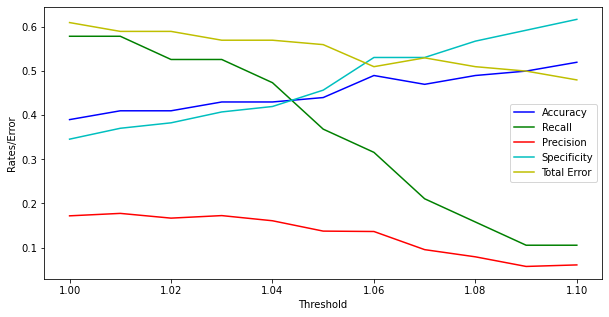

In [20]:
max_value = max(data.euclidean_distance)
min_value = min(data.euclidean_distance)
threshold = np.arange(1.0,1.1,0.01)

precision=[]
accuracy=[]
recall=[]
specificity=[]

for i in range(0,len(threshold)):
    data['y_pred'] = ''
    data['cm'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['euclidean_distance'][j] >= threshold[i]):
            data['y_pred'][j] = 'Y'
        else:
            data['y_pred'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'N'):
            data['cm'][k] = 'FN'
        else:
            data['cm'][k] = 'TN'
    
    
    tp = data.cm.value_counts().TP if 'TP' in data.cm.value_counts() is not None else 0
    tn = data.cm.value_counts().TN if 'TN' in data.cm.value_counts() is not None else 0
    fp = data.cm.value_counts().FP if 'FP' in data.cm.value_counts() is not None else 0
    fn = data.cm.value_counts().FN if 'FN' in data.cm.value_counts() is not None else 0

    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    precision.append(prec)
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    recall.append(rec)
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    accuracy.append(acc)
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    specificity.append(spec)

plt.figure(figsize=(10,5))

plt.plot(threshold, accuracy, color = 'b', label = 'Accuracy')
plt.plot(threshold, recall, color = 'g', label = 'Recall')
plt.plot(threshold, precision, color = 'r', label = 'Precision')
plt.plot(threshold, specificity, color = 'c', label = 'Specificity')
plt.plot(threshold, [1-x for x in accuracy], color = 'y', label = 'Total Error')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [21]:
threshold = np.arange(1.0,1.1,0.01)
results3 = pd.DataFrame(threshold,columns=['threshold'])
results3['TP'] = ''
results3['TN'] = ''
results3['FP'] = ''
results3['FN'] = ''

results3['specificity'] = ''
results3['recall']=''
results3['precision']=''
results3['accuracy']=''

for i in range(0,len(threshold)):
    threshold = results3['threshold'][i]
    data['y_euclid'] = ''
    data['cm_euclid'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['euclidean_distance'][j] >= threshold):
            data['y_euclid'][j] = 'Y'
        else:
            data['y_euclid'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_euclid'][k] == 'Y'):
            data['cm_euclid'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_euclid'][k] == 'Y'):
            data['cm_euclid'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_euclid'][k] == 'N'):
            data['cm_euclid'][k] = 'FN'
        else:
            data['cm_euclid'][k] = 'TN'
    
    
    tp = data.cm_euclid.value_counts().TP if 'TP' in data.cm_euclid.value_counts() is not None else 0
    results3['TP'][i] = tp
    
    tn = data.cm_euclid.value_counts().TN if 'TN' in data.cm_euclid.value_counts() is not None else 0
    results3['TN'][i] = tn
    
    fp = data.cm_euclid.value_counts().FP if 'FP' in data.cm_euclid.value_counts() is not None else 0
    results3['FP'][i] = fp
    
    fn = data.cm_euclid.value_counts().FN if 'FN' in data.cm_euclid.value_counts() is not None else 0
    results3['FN'][i] = fn
    
    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    results3['precision'][i] = prec

    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    results3['recall'][i] = rec

    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    results3['accuracy'][i] = acc 

    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    results3['specificity'][i] = spec

print('---------- USE: Euclidean Distance ----------')
results3

---------- USE: Euclidean Distance ----------


,threshold,TP,TN,FP,FN,specificity,recall,precision,accuracy
0,1.00,11,28,53,8,0.345679,0.578947,0.171875,0.39
1,1.01,11,30,51,8,0.37037,0.578947,0.177419,0.41
2,1.02,10,31,50,9,0.382716,0.526316,0.166667,0.41
3,1.03,10,33,48,9,0.407407,0.526316,0.172414,0.43
4,1.04,9,34,47,10,0.419753,0.473684,0.160714,0.43
5,1.05,7,37,44,12,0.45679,0.368421,0.137255,0.44
6,1.06,6,43,38,13,0.530864,0.315789,0.136364,0.49
7,1.07,4,43,38,15,0.530864,0.210526,0.0952381,0.47
8,1.08,3,46,35,16,0.567901,0.157895,0.0789474,0.49
9,1.09,2,48,33,17,0.592593,0.105263,0.0571429,0.5


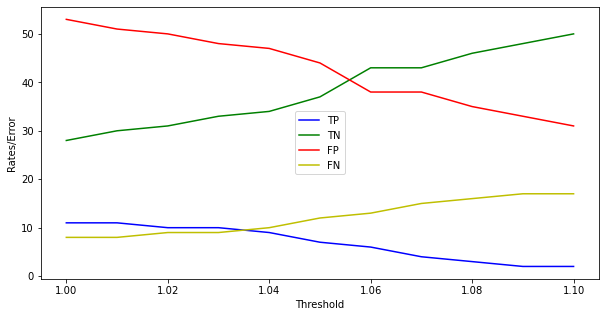

In [22]:
tp_list = results3.TP.to_list()
tn_list = results3.TN.to_list()
fp_list = results3.FP.to_list()
fn_list = results3.FN.to_list()

plt.figure(figsize=(10,5))

threshold = np.arange(1.0,1.1,0.01)

plt.plot(threshold,tp_list, color = 'b', label = 'TP')
plt.plot(threshold,tn_list, color = 'g', label = 'TN')
plt.plot(threshold,fp_list, color = 'r', label = 'FP')
plt.plot(threshold,fn_list, color = 'y', label = 'FN')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [23]:
data['y_euclid']=''
for i in range(0,len(data)):
    if data['euclidean_distance'][i] >= 0.92:
        data['y_euclid'][i] = 'Y'
    else:
        data['y_euclid'][i] = 'N'
        
data['cm_euclid']=''
for k in range(0,len(data)):
    if (data['truth'][k] == 'Y') and (data['y_euclid'][k] == 'Y'):
        data['cm_euclid'][k] = 'TP'
    elif (data['truth'][k] == 'N') and (data['y_euclid'][k] == 'Y'):
        data['cm_euclid'][k] = 'FP'
    elif (data['truth'][k] == 'Y') and (data['y_euclid'][k] == 'N'):
        data['cm_euclid'][k] = 'FN'
    else:
        data['cm_euclid'][k] = 'TN'
        
tp = data.cm_euclid.value_counts().TP if 'TP' in data.cm_euclid.value_counts() is not None else 0
print('true positives:',tp)
tn = data.cm_euclid.value_counts().TN if 'TN' in data.cm_euclid.value_counts() is not None else 0
print('true negatives:',tn)
fp = data.cm_euclid.value_counts().FP if 'FP' in data.cm_euclid.value_counts() is not None else 0
print('false positives:',fp)
fn = data.cm_euclid.value_counts().FN if 'FN' in data.cm_euclid.value_counts() is not None else 0
print('false negatives:',fn)

precision = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
print('precision:',precision)

specificity = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
print('specificity:',specificity)
    
recall = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
print('recall:',recall)   

acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
print('accuracy:',acc)

true positives: 15
true negatives: 15
false positives: 66
false negatives: 4
precision: 0.18518518518518517
specificity: 0.18518518518518517
recall: 0.7894736842105263
accuracy: 0.3


#### tss

In [24]:
print(max(data.tss))
print(min(data.tss))

0.011298826
0.0010777187


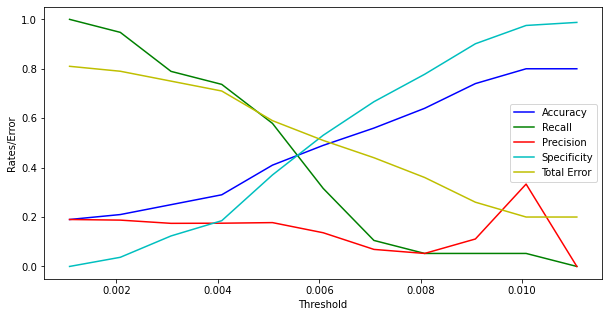

In [25]:
max_value = max(data.tss)
min_value = min(data.tss)
threshold = np.arange(min_value,max_value,0.001)

precision=[]
accuracy=[]
recall=[]
specificity=[]

for i in range(0,len(threshold)):
    data['y_pred'] = ''
    data['cm'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['tss'][j] >= threshold[i]):
            data['y_pred'][j] = 'Y'
        else:
            data['y_pred'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'N'):
            data['cm'][k] = 'FN'
        else:
            data['cm'][k] = 'TN'
    
    
    tp = data.cm.value_counts().TP if 'TP' in data.cm.value_counts() is not None else 0
    tn = data.cm.value_counts().TN if 'TN' in data.cm.value_counts() is not None else 0
    fp = data.cm.value_counts().FP if 'FP' in data.cm.value_counts() is not None else 0
    fn = data.cm.value_counts().FN if 'FN' in data.cm.value_counts() is not None else 0

    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    precision.append(prec)
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    recall.append(rec)
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    accuracy.append(acc)
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    specificity.append(spec)

plt.figure(figsize=(10,5))

plt.plot(threshold, accuracy, color = 'b', label = 'Accuracy')
plt.plot(threshold, recall, color = 'g', label = 'Recall')
plt.plot(threshold, precision, color = 'r', label = 'Precision')
plt.plot(threshold, specificity, color = 'c', label = 'Specificity')
plt.plot(threshold, [1-x for x in accuracy], color = 'y', label = 'Total Error')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [26]:
threshold = np.arange(0.002,0.008,0.001)
results4 = pd.DataFrame(threshold,columns=['threshold'])
results4['TP'] = ''
results4['TN'] = ''
results4['FP'] = ''
results4['FN'] = ''

results4['specificity'] = ''
results4['recall']=''
results4['precision']=''
results4['accuracy']=''

for i in range(0,len(threshold)):
    threshold = results4['threshold'][i]
    data['y_tss'] = ''
    data['cm_tss'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['tss'][j] >= threshold):
            data['y_tss'][j] = 'Y'
        else:
            data['y_tss'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_tss'][k] == 'Y'):
            data['cm_tss'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_tss'][k] == 'Y'):
            data['cm_tss'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_tss'][k] == 'N'):
            data['cm_tss'][k] = 'FN'
        else:
            data['cm_tss'][k] = 'TN'
    
    
    tp = data.cm_tss.value_counts().TP if 'TP' in data.cm_tss.value_counts() is not None else 0
    results4['TP'][i] = tp
    
    tn = data.cm_tss.value_counts().TN if 'TN' in data.cm_tss.value_counts() is not None else 0
    results4['TN'][i] = tn
    
    fp = data.cm_tss.value_counts().FP if 'FP' in data.cm_tss.value_counts() is not None else 0
    results4['FP'][i] = fp
    
    fn = data.cm_tss.value_counts().FN if 'FN' in data.cm_tss.value_counts() is not None else 0
    results4['FN'][i] = fn
    
    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    results4['precision'][i] = prec

    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    results4['recall'][i] = rec

    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    results4['accuracy'][i] = acc 

    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    results4['specificity'][i] = spec

print('---------- USE: TS-SS ----------')    
results4

---------- USE: TS-SS ----------


,threshold,TP,TN,FP,FN,specificity,recall,precision,accuracy
0,0.002,18,3,78,1,0.037037,0.947368,0.1875,0.21
1,0.003,15,8,73,4,0.0987654,0.789474,0.170455,0.23
2,0.004,14,15,66,5,0.185185,0.736842,0.175,0.29
3,0.005,11,28,53,8,0.345679,0.578947,0.171875,0.39
4,0.006,7,41,40,12,0.506173,0.368421,0.148936,0.48
5,0.007,2,52,29,17,0.641975,0.105263,0.0645161,0.54


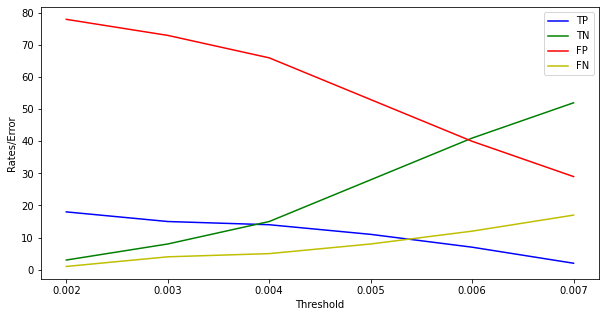

In [27]:
tp_list = results4.TP.to_list()
tn_list = results4.TN.to_list()
fp_list = results4.FP.to_list()
fn_list = results4.FN.to_list()

plt.figure(figsize=(10,5))

threshold = np.arange(0.002,0.008,0.001)

plt.plot(threshold,tp_list, color = 'b', label = 'TP')
plt.plot(threshold,tn_list, color = 'g', label = 'TN')
plt.plot(threshold,fp_list, color = 'r', label = 'FP')
plt.plot(threshold,fn_list, color = 'y', label = 'FN')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [28]:
data['y_tss']=''
for i in range(0,len(data)):
    if data['tss'][i] >= 0.004:
        data['y_tss'][i] = 'Y'
    else:
        data['y_tss'][i] = 'N'
        
data['cm_tss']=''
for k in range(0,len(data)):
    if (data['truth'][k] == 'Y') and (data['y_tss'][k] == 'Y'):
        data['cm_tss'][k] = 'TP'
    elif (data['truth'][k] == 'N') and (data['y_tss'][k] == 'Y'):
        data['cm_tss'][k] = 'FP'
    elif (data['truth'][k] == 'Y') and (data['y_tss'][k] == 'N'):
        data['cm_tss'][k] = 'FN'
    else:
        data['cm_tss'][k] = 'TN'
        
tp = data.cm_tss.value_counts().TP if 'TP' in data.cm_tss.value_counts() is not None else 0
print('true positives:',tp)
tn = data.cm_tss.value_counts().TN if 'TN' in data.cm_tss.value_counts() is not None else 0
print('true negatives:',tn)
fp = data.cm_tss.value_counts().FP if 'FP' in data.cm_tss.value_counts() is not None else 0
print('false positives:',fp)
fn = data.cm_tss.value_counts().FN if 'FN' in data.cm_tss.value_counts() is not None else 0
print('false negatives:',fn)

precision = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
print('precision:',precision)

specificity = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
print('specificity:',specificity)
    
recall = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
print('recall:',recall)   

acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
print('accuracy:',acc)

true positives: 14
true negatives: 15
false positives: 66
false negatives: 5
precision: 0.175
specificity: 0.18518518518518517
recall: 0.7368421052631579
accuracy: 0.29


#### cosine

In [29]:
print(max(data.cosine))
print(min(data.cosine))

0.79603857
0.17500961


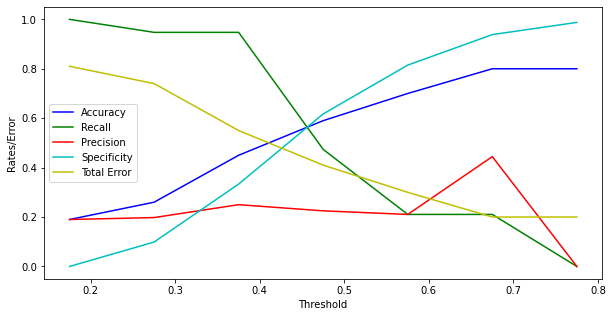

In [30]:
max_value = max(data.cosine)
min_value = min(data.cosine)
threshold = np.arange(min_value,max_value,0.1)

precision=[]
accuracy=[]
recall=[]
specificity=[]

for i in range(0,len(threshold)):
    data['y_pred'] = ''
    data['cm'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['cosine'][j] >= threshold[i]):
            data['y_pred'][j] = 'Y'
        else:
            data['y_pred'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'N'):
            data['cm'][k] = 'FN'
        else:
            data['cm'][k] = 'TN'
    
    
    tp = data.cm.value_counts().TP if 'TP' in data.cm.value_counts() is not None else 0
    tn = data.cm.value_counts().TN if 'TN' in data.cm.value_counts() is not None else 0
    fp = data.cm.value_counts().FP if 'FP' in data.cm.value_counts() is not None else 0
    fn = data.cm.value_counts().FN if 'FN' in data.cm.value_counts() is not None else 0

    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    precision.append(prec)
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    recall.append(rec)
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    accuracy.append(acc)
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    specificity.append(spec)

plt.figure(figsize=(10,5))

plt.plot(threshold, accuracy, color = 'b', label = 'Accuracy')
plt.plot(threshold, recall, color = 'g', label = 'Recall')
plt.plot(threshold, precision, color = 'r', label = 'Precision')
plt.plot(threshold, specificity, color = 'c', label = 'Specificity')
plt.plot(threshold, [1-x for x in accuracy], color = 'y', label = 'Total Error')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [31]:
threshold = np.arange(0.4,0.5,0.01)
results5 = pd.DataFrame(threshold,columns=['threshold'])
results5['TP'] = ''
results5['TN'] = ''
results5['FP'] = ''
results5['FN'] = ''

results5['specificity'] = ''
results5['recall']=''
results5['precision']=''
results5['accuracy']=''

for i in range(0,len(threshold)):
    threshold = results5['threshold'][i]
    data['y_cosine'] = ''
    data['cm_cosine'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['cosine'][j] >= threshold):
            data['y_cosine'][j] = 'Y'
        else:
            data['y_cosine'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_cosine'][k] == 'Y'):
            data['cm_cosine'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_cosine'][k] == 'Y'):
            data['cm_cosine'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_cosine'][k] == 'N'):
            data['cm_cosine'][k] = 'FN'
        else:
            data['cm_cosine'][k] = 'TN'
    
    
    tp = data.cm_cosine.value_counts().TP if 'TP' in data.cm_cosine.value_counts() is not None else 0
    results5['TP'][i] = tp
    
    tn = data.cm_cosine.value_counts().TN if 'TN' in data.cm_cosine.value_counts() is not None else 0
    results5['TN'][i] = tn
    
    fp = data.cm_cosine.value_counts().FP if 'FP' in data.cm_cosine.value_counts() is not None else 0
    results5['FP'][i] = fp
    
    fn = data.cm_cosine.value_counts().FN if 'FN' in data.cm_cosine.value_counts() is not None else 0
    results5['FN'][i] = fn
    
    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    results5['precision'][i] = prec

    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    results5['recall'][i] = rec

    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    results5['accuracy'][i] = acc 
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    results5['specificity'][i] = spec

print('---------- USE: Cosine Similarity ----------')    
results5

---------- USE: Cosine Similarity ----------


,threshold,TP,TN,FP,FN,specificity,recall,precision,accuracy
0,0.40,17,31,50,2,0.382716,0.894737,0.253731,0.48
1,0.41,17,33,48,2,0.407407,0.894737,0.261538,0.5
2,0.42,16,36,45,3,0.444444,0.842105,0.262295,0.52
3,0.43,15,38,43,4,0.469136,0.789474,0.258621,0.53
4,0.44,13,39,42,6,0.481481,0.684211,0.236364,0.52
5,0.45,12,45,36,7,0.555556,0.631579,0.25,0.57
6,0.46,10,47,34,9,0.580247,0.526316,0.227273,0.57
7,0.47,9,48,33,10,0.592593,0.473684,0.214286,0.57
8,0.48,9,50,31,10,0.617284,0.473684,0.225,0.59
9,0.49,8,51,30,11,0.62963,0.421053,0.210526,0.59


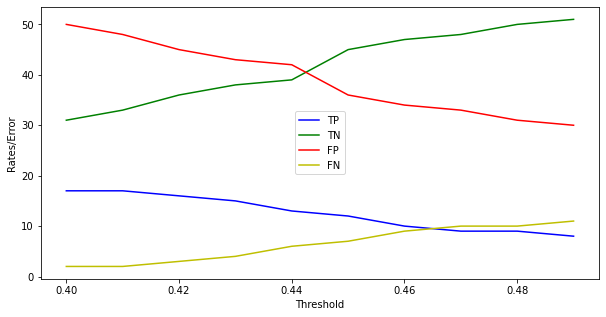

In [32]:
tp_list = results5.TP.to_list()
tn_list = results5.TN.to_list()
fp_list = results5.FP.to_list()
fn_list = results5.FN.to_list()

plt.figure(figsize=(10,5))

threshold = np.arange(0.4,0.5,0.01)

plt.plot(threshold,tp_list, color = 'b', label = 'TP')
plt.plot(threshold,tn_list, color = 'g', label = 'TN')
plt.plot(threshold,fp_list, color = 'r', label = 'FP')
plt.plot(threshold,fn_list, color = 'y', label = 'FN')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [33]:
data['y_cosine']=''
for i in range(0,len(data)):
    if data['cosine'][i] >= 0.42:
        data['y_cosine'][i] = 'Y'
    else:
        data['y_cosine'][i] = 'N'
        
data['cm_cosine']=''
for k in range(0,len(data)):
    if (data['truth'][k] == 'Y') and (data['y_cosine'][k] == 'Y'):
        data['cm_cosine'][k] = 'TP'
    elif (data['truth'][k] == 'N') and (data['y_cosine'][k] == 'Y'):
        data['cm_cosine'][k] = 'FP'
    elif (data['truth'][k] == 'Y') and (data['y_cosine'][k] == 'N'):
        data['cm_cosine'][k] = 'FN'
    else:
        data['cm_cosine'][k] = 'TN'

tp = data.cm_cosine.value_counts().TP if 'TP' in data.cm_cosine.value_counts() is not None else 0
print('true positives:',tp)
tn = data.cm_cosine.value_counts().TN if 'TN' in data.cm_cosine.value_counts() is not None else 0
print('true negatives:',tn)
fp = data.cm_cosine.value_counts().FP if 'FP' in data.cm_cosine.value_counts() is not None else 0
print('false positives:',fp)
fn = data.cm_cosine.value_counts().FN if 'FN' in data.cm_cosine.value_counts() is not None else 0
print('false negatives:',fn)

precision = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
print('precision:',precision)

specificity = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
print('specificity:',specificity)
    
recall = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
print('recall:',recall)   

acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
print('accuracy:',acc)

true positives: 16
true negatives: 36
false positives: 45
false negatives: 3
precision: 0.26229508196721313
specificity: 0.4444444444444444
recall: 0.8421052631578947
accuracy: 0.52


In [34]:
data.drop(['y_pred', 'cm'], axis=1, inplace=True)
data.to_excel('use.xlsx',index=False)